In [52]:
!pip install -q yfinance
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, ConvLSTM2D, Conv2D, BatchNormalization


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

In [53]:
pip install -q -U keras-tuner


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import kerastuner as kt
from kerastuner import Objective
from kerastuner import HyperModel
from kerastuner import HyperParameters
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel

In [56]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [57]:
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

stock_data = {}

stock_data["STM"] = yf.download("STM", start, end)

STM = stock_data["STM"]

[*********************100%%**********************]  1 of 1 completed


In [58]:
STM["Company"] = "STM"
print(STM.head(10))
print(STM.describe())
print(STM.info())




            Open  High   Low  Close  Adj Close   Volume Company
Date                                                           
2014-03-12  9.22  9.28  9.16   9.28   7.575920  1212900     STM
2014-03-13  9.33  9.34  9.13   9.16   7.477956  1738600     STM
2014-03-14  9.05  9.16  9.03   9.13   7.453463  2872800     STM
2014-03-17  9.21  9.33  9.20   9.25   7.551429  1674300     STM
2014-03-18  9.29  9.38  9.28   9.36   7.641229   804900     STM
2014-03-19  9.34  9.36  9.18   9.22   7.526937   488100     STM
2014-03-20  9.24  9.45  9.23   9.40   7.673883   349100     STM
2014-03-21  9.49  9.49  9.32   9.33   7.616737   445000     STM
2014-03-24  9.32  9.32  9.15   9.26   7.641497   525800     STM
2014-03-25  9.27  9.30  9.16   9.29   7.666253   685200     STM
              Open         High          Low        Close    Adj Close  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000   
mean     24.149456    24.411367    23.874696    24.153365    23.478087   
std      1

Viewing History of Closing Price

Text(0.5, 1.0, 'Adj Closing Price STMicroelectronics in 20 years')

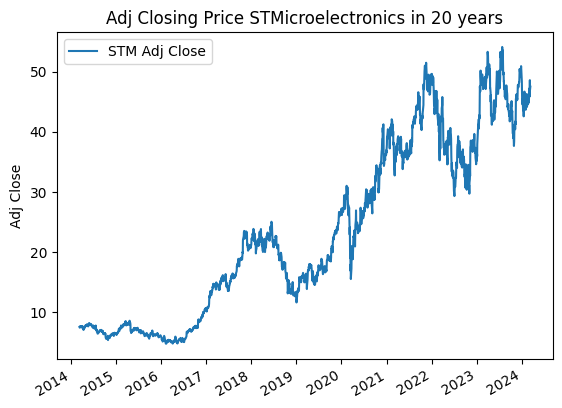

In [59]:
# # Let's see a historical view of the closing price

STM['Adj Close'].plot(label="STM Adj Close")
plt.legend()

plt.ylabel('Adj Close')
plt.xlabel(None)

plt.title(f"Adj Closing Price STMicroelectronics in 20 years")


Text(0.5, 1.0, 'Adj Closing Price STMicroelectronics in 20 years, with Moving Average')

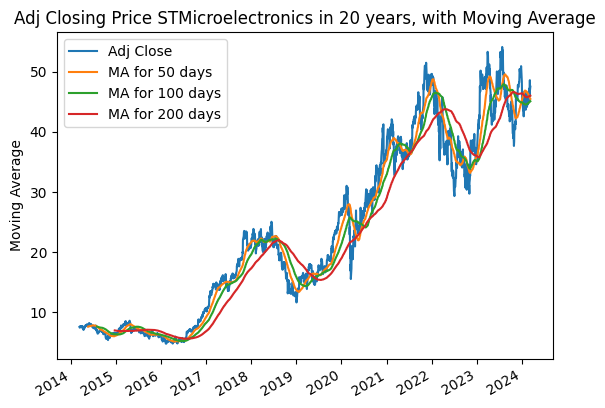

In [60]:
ma_day = [50, 100, 200]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    STM[column_name] = STM['Adj Close'].rolling(ma).mean()


STM[['Adj Close', 'MA for 50 days', 'MA for 100 days', 'MA for 200 days']].plot(label="STM Adj Close")

plt.ylabel('Moving Average')
plt.xlabel(None)

plt.title(f"Adj Closing Price STMicroelectronics in 20 years, with Moving Average")

In [61]:
STM

,Open,High,Low,Close,Adj Close,Volume,Company,MA for 50 days,MA for 100 days,MA for 200 days
Date,,,,,,,,,,
2014-03-12,9.220000,9.280000,9.160000,9.280000,7.575920,1212900,STM,NaN,NaN,NaN
2014-03-13,9.330000,9.340000,9.130000,9.160000,7.477956,1738600,STM,NaN,NaN,NaN
2014-03-14,9.050000,9.160000,9.030000,9.130000,7.453463,2872800,STM,NaN,NaN,NaN
2014-03-17,9.210000,9.330000,9.200000,9.250000,7.551429,1674300,STM,NaN,NaN,NaN
2014-03-18,9.290000,9.380000,9.280000,9.360000,7.641229,804900,STM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-03-05,46.220001,46.419998,45.470001,45.849998,45.849998,3468200,STM,45.6928,44.932544,45.945172
2024-03-06,46.220001,47.250000,45.980000,46.860001,46.860001,4194000,STM,45.6252,44.950209,45.957792
2024-03-07,47.450001,49.049999,47.419998,48.570000,48.570000,4504900,STM,45.5942,44.992566,45.976323


In [62]:
# Create a new dataframe with only the 'Close column
data = STM.filter(['Open', 'High',	'Low',	'Close',	'Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
look_back = 50
n_features = 1
train_testsplit = 0.8

In [63]:
dataset.shape

(2517, 5)

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(2517, 5)

In [65]:
type(scaled_data)

numpy.ndarray

In [66]:
# Split the data into x_train and y_train data sets
x_list = []
y_list = []

sos_array = np.full((1, 5), 0)  #-1 is a distinguisherable value outside of the minmax range of 0-1
eos_array = np.full((1, 5), 1)  #2 is a distinguisherable value outside of the minmax range of 0-1

for i in range(look_back, len(scaled_data)-look_back):
    x_list.append(scaled_data[i-look_back:i, :])
    y_list.append(scaled_data[i:i+look_back, :])

x_input = []
y_input = []
y_output = []

for i in x_list:
  i_x_input = np.vstack([sos_array, i])
  x_input.append(i_x_input)

for i in y_list:
  i_y_input = np.vstack([sos_array, i])
  y_input.append(i_y_input)

  i_y_output = np.vstack([i, eos_array])
  y_output.append(i_y_output)

In [67]:
x_input, y_input, y_output = np.array(x_input), np.array(y_input), np.array(y_output)


print(x_input.shape)
print(y_input.shape)
print(y_output.shape)

(2417, 51, 5)
(2417, 51, 5)
(2417, 51, 5)


In [68]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(x_input) * train_testsplit))
# print("training_data_len", training_data_len)

x_train = x_input[:training_data_len, :, :]
y_train_input = y_input[:training_data_len, :, :]
y_train_output = y_output[:training_data_len, :, :]

x_test = x_input[training_data_len:, :, :]
y_test_input = y_input[training_data_len:, :, :]
y_test_output = y_output[training_data_len:, :, :]

print("x_train's shape",  x_train.shape)
print("y_train_input's shape", y_train_input.shape)
print("y_train_output's shape", y_train_output.shape)

print("x_test's shape",  x_test.shape)
print("y_test_input's shape", y_test_input.shape)
print("y_test_output's shape", y_test_output.shape)

x_train's shape (1934, 51, 5)
y_train_input's shape (1934, 51, 5)
y_train_output's shape (1934, 51, 5)
x_test's shape (483, 51, 5)
y_test_input's shape (483, 51, 5)
y_test_output's shape (483, 51, 5)


In [69]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2],  1, 1))
y_train_input = np.reshape(y_train_input, (y_train_input.shape[0], y_train_input.shape[1], y_train_input.shape[2], 1, 1))
y_train_output = np.reshape(y_train_output, (y_train_output.shape[0], y_train_output.shape[1], y_train_output.shape[2], 1, 1))


print(x_train.shape)
print(y_train_input.shape)
print(y_train_output.shape)

(1934, 51, 5, 1, 1)
(1934, 51, 5, 1, 1)
(1934, 51, 5, 1, 1)


In [70]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2],  1, 1))
y_test_input = np.reshape(y_test_input, (y_test_input.shape[0], y_test_input.shape[1], y_test_input.shape[2], 1, 1))
y_test_output = np.reshape(y_test_output, (y_test_output.shape[0], y_test_output.shape[1], y_test_output.shape[2], 1, 1))


print(x_test.shape)
print(y_test_input.shape)
print(y_test_output.shape)

(483, 51, 5, 1, 1)
(483, 51, 5, 1, 1)
(483, 51, 5, 1, 1)


In [75]:
  ##########################
  ##### build the model #####
class HyperRegressor(HyperModel):

    def build_model(self, hp, *args):

        encoder_states = []
        # Define the input layer
        encoder_inputs_placeholder = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]))
        encoder = ConvLSTM2D(filters=hp.Choice(f"layerfilters", [32, 64, 96]), kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True)
        encoder_outputs, h, c = encoder(encoder_inputs_placeholder )
        encoder_states.append([h, c])
        # keep only the states to pass into decoder

        print(len(encoder_states))
        # Set up the decoder, using [h, c] as initial state.
        decoder_inputs_placeholder = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]))

        # since the decoder is a "to-many" model we want to have return_sequences=True
        decoder_lstm = ConvLSTM2D(filters=hp.Choice(f"layerfilters", [32, 64, 96]), kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs_placeholder, initial_state=encoder_states[-1])

        # final dense layer for predictions
        decoder_dense2 = Dense(1, activation='linear')
        decoder_outputs = decoder_dense2(decoder_outputs)
        # Create the model object
        model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
        #Compile the model and train it
        model.compile(optimizer="adam", loss='mae', metrics='mae')

        return model, encoder_inputs_placeholder, encoder_states, decoder_lstm, decoder_dense2

    def _build_wrapper(self, hp):
        model, encoder_inputs_placeholder, encoder_states, decoder_lstm, decoder_dense2 = self.build_model(hp)
        return model



    def fit(self, hp, model, x_train, y_train_input, y_train_output, validation_data, *args, **kwargs):
        model.fit([x_train, y_train_input], y_train_output, **kwargs)
        [[x_test, y_test_input], y_test_output] = validation_data
        predictions = model.predict([x_test, y_test_input])

        predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1],predictions.shape[2]))
        y_test_output = np.reshape(y_test_output, (y_test_output.shape[0], y_test_output.shape[1],y_test_output.shape[2]))

        prediction_rev_scaled = []
        y_test_rev_scaled = []

        for i in predictions:
          i_prediction = scaler.inverse_transform(i)
          prediction_rev_scaled.append(i_prediction)

        for i in y_test_output:
          i_y_test = scaler.inverse_transform(i)
          y_test_rev_scaled.append(i_y_test)

        prediction_rev_scaled = np.array(prediction_rev_scaled)
        y_test_rev_scaled = np.array(y_test_rev_scaled)


        # Return a single float to minimize.
        return {"Rev_scaled_Val_MAE": K.mean(K.abs(prediction_rev_scaled - y_test_rev_scaled), axis=(0,1)).numpy()[4]} #[4] means adj close price will be used as the objective


In [76]:
tuner = RandomSearch(
    hypermodel=HyperRegressor(),
    objective=Objective("Rev_scaled_Val_MAE", "min"),
    max_trials=3,
    directory="/content/drive/MyDrive/Colab Notebooks/Stock_Data Analysis/With 50 days trend accuracy/Without Data Leak",
    project_name="Checkpoint_Folder_Seq2seq_with_Custom_Metric_for_Tuner_Round2",
    overwrite=True,
)

from keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='mae', patience=3)
tuner.search(x_train, y_train_input, y_train_output, epochs=5, batch_size=1, validation_data=[[x_test, y_test_input], y_test_output], verbose=1, callbacks=[early_stopping_callback])

Trial 3 Complete [00h 05m 22s]
Rev_scaled_Val_MAE: 1.0287178167156454

Best Rev_scaled_Val_MAE So Far: 1.0287178167156454
Total elapsed time: 00h 19m 48s


In [77]:
best_hp = tuner.get_best_hyperparameters()[0]
print(f"""The hyperparameter search is complete. The best layer filter is {best_hp.get("layerfilters")}""")

The hyperparameter search is complete. The best layer filter is 32


In [78]:
best_model = tuner.get_best_models()[0]
best_model.summary()

1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51, 5, 1, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 51, 5, 1, 1)]        0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    [(None, 51, 5, 1, 32),       12800     ['input_1[0][0]']             
                              (None, 5, 1, 32),                                                   
                              (None, 5, 1, 32)]                                                   
                                                                                            

In [80]:
def error_calculator(predictions, y_test_output):

    predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1],predictions.shape[2]))
    y_test_output = np.reshape(y_test_output, (y_test_output.shape[0], y_test_output.shape[1],y_test_output.shape[2]))

    prediction_rev_scaled = []
    y_test_rev_scaled = []

    for i in predictions:
      i_prediction = scaler.inverse_transform(i)
      prediction_rev_scaled.append(i_prediction)

    for i in y_test_output:
      i_y_test = scaler.inverse_transform(i)
      y_test_rev_scaled.append(i_y_test)

    prediction_rev_scaled = np.array(prediction_rev_scaled)
    y_test_rev_scaled = np.array(y_test_rev_scaled)

    # print("Prediction shape", prediction_rev_scaled.shape)
    # print("y_test shape", y_test_rev_scaled.shape)
    # print(predictions)
    # print(y_test)

    # Get the rmse, mae and mape
    rmse = np.sqrt(np.mean(np.square(prediction_rev_scaled - y_test_rev_scaled), axis=(0,1)))
    print("rmse is" , rmse)
    mae = K.mean(K.abs(prediction_rev_scaled - y_test_rev_scaled), axis=(0,1)).numpy()
    print("mae is" , mae)
    mape = (K.mean(K.abs(prediction_rev_scaled - y_test_rev_scaled)/K.maximum(K.abs(y_test_rev_scaled), K.epsilon()), axis=(0,1))*100).numpy()
    print("mape is" , mape)

    return prediction_rev_scaled, y_test_rev_scaled


In [82]:
#build the model

encoder_states = []
# Define the input layer
encoder_inputs_placeholder = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]))
encoder = ConvLSTM2D(filters=best_hp["layerfilters"], kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True)

encoder_outputs, h, c = encoder(encoder_inputs_placeholder)
encoder_states.append([h, c])
# keep only the states to pass into decoder


# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]))

# since the decoder is a "to-many" model we want to have return_sequences=True
decoder_lstm = ConvLSTM2D(filters=best_hp["layerfilters"], kernel_size=(1, 3),padding='same', return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_placeholder, initial_state=encoder_states[-1])

# final dense layer for predictions
decoder_dense2 = Dense(1, activation='linear')
decoder_outputs = decoder_dense2(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
#Compile the model and train it
model.compile(optimizer="adam", loss='mae', metrics='mae')



BATCH_SIZE = 1
EPOCHS = 5
from keras.callbacks import EarlyStopping

r = model.fit([x_train, y_train_input], y_train_output, batch_size=BATCH_SIZE, validation_data=[[x_test, y_test_input], y_test_output], epochs=EPOCHS, callbacks=EarlyStopping(patience=1))

Epoch 1/5
1934/1934 [==============================] - 90s 45ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0254 - val_mae: 0.0254
Epoch 2/5
1934/1934 [==============================] - 96s 50ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 3/5
1934/1934 [==============================] - 92s 48ms/step - loss: 0.0217 - mae: 0.0217 - val_loss: 0.0216 - val_mae: 0.0216
Epoch 4/5
1934/1934 [==============================] - 101s 52ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0206 - val_mae: 0.0206
Epoch 5/5
1934/1934 [==============================] - 101s 52ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0206 - val_mae: 0.0206


In [83]:
r.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 51, 5, 1, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 51, 5, 1, 1)]        0         []                            
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)  [(None, 51, 5, 1, 32),       12800     ['input_5[0][0]']             
                              (None, 5, 1, 32),                                                   
                              (None, 5, 1, 32)]                                                   
                                                                                            

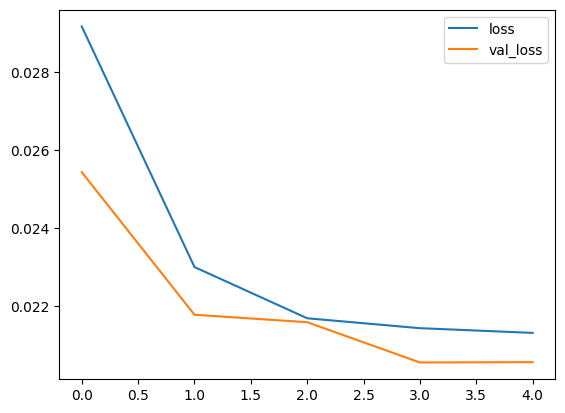

In [84]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

To show the train MAE after reversed scaled

In [85]:
# Reshape the data
print("x_train", x_train.shape)

# Get the models predicted price values
train_predictions = r.model.predict([x_train, y_train_input])
prediction_rev_scaled, y_train_rev_scaled = error_calculator(train_predictions, y_train_output)

x_train (1934, 51, 5, 1, 1)
61/61 [==============================] - 3s 40ms/step
rmse is [5.14749798 5.25136592 5.07395034 5.06820633 5.14985358]
mae is [1.04267581 1.02658864 1.01281846 1.03217884 1.03045296]
mape is [3.08831278 2.94786921 3.05451113 3.09580377 3.12234401]


To show the test MAE after reversed scaled

In [86]:
# Reshape the data
print("x_test", x_test.shape)

# Get the models predicted price values
predictions = r.model.predict([x_test, y_test_input])
prediction_rev_scaled, y_test_rev_scaled = error_calculator(predictions, y_test_output)

x_test (483, 51, 5, 1, 1)
16/16 [==============================] - 1s 38ms/step
rmse is [2.22839615 2.2289101  2.15486095 2.13614664 2.14104126]
mae is [1.0630383  0.99008872 0.97151647 1.03546268 1.03231921]
mape is [2.44538423 2.22493243 2.2413025  2.38915264 2.39303462]


In [87]:
# Reshape the data
print("x_test", x_test.shape)

# Get the models predicted price values
predictions = r.model.predict([x_test, y_test_input])
prediction_rev_scaled, y_test_rev_scaled = error_calculator(predictions, y_test_output)

x_test (483, 51, 5, 1, 1)
16/16 [==============================] - 1s 36ms/step
rmse is [2.22839615 2.2289101  2.15486095 2.13614664 2.14104126]
mae is [1.0630383  0.99008872 0.97151647 1.03546268 1.03231921]
mape is [2.44538423 2.22493243 2.2413025  2.38915264 2.39303462]


In [88]:
#the prediction model

encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(5, 1, best_hp["layerfilters"]))
decoder_state_input_c = Input(shape=(5, 1, best_hp["layerfilters"]))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1, x_test.shape[2], x_test.shape[3], x_test.shape[4]))

# this time, we want to keep the states too, to be output by our sampling model
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single, initial_state=decoder_states_inputs)

decoder_states = [h, c]

decoder_outputs = decoder_dense2(decoder_outputs)

decoder_model = Model( [decoder_inputs_single] + decoder_states_inputs,  [decoder_outputs] + decoder_states)

In [89]:
def decode_sequence(input_seq):


  states_value = encoder_model.predict(input_seq)
  # h_states_value = np.array(h)
  # c_states_value = np.array(c)
  # print(h_states_value.shape)
  # print(c_states_value.shape)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, 5, 1, 1))
  target_seq[0, 0, :, 0, 0] = 0
  # print(target_seq)


    # Create the translation
  output_sentence = []

  for _ in range(y_test_output.shape[1]):
    output_value, h, c = decoder_model.predict([target_seq , states_value])
    print(output_value.shape)

    for each in output_value:

      if output_value.any() > 0:
        # print("output_value", output_value)
        output_value2append = np.reshape(output_value, (5,1,1))
        output_sentence.append(output_value2append)

      # print("Target seq shape" , target_seq.shape)
      # print("Output value shape", output_value.shape)

      print(output_value)
      # Update the decoder input
      # which is just the word just generated
      target_seq = output_value

      # Update states
      states_value = [h, c]

  return output_sentence

In [90]:
# Do trend prediction
def trend_pred(x_test):
  final_prediction = []

  for i, each_batch in enumerate(x_test):
    # print("Batch", i)
    # print("input_seq", each_batch)
    each_batch = each_batch.reshape(1, x_test.shape[1], x_test.shape[2], x_test.shape[3], x_test.shape[4])
    # print("input_seq shape", each_batch.shape)

    Pred_seq = decode_sequence(each_batch)
    # print('-')
    # print('Input seq of:', each_batch)
    # print('Translation:', Pred_seq)

    final_prediction.append(Pred_seq)
    # print("final pred seq", final_prediction)
   # if i==10:
   #   break

  return final_prediction


In [91]:
pred_wo_teac_forcing = trend_pred(x_test)


Streaming output truncated to the last 5000 lines.
[[[[[0.8931339 ]]

   [[0.88778424]]

   [[0.8998436 ]]

   [[0.91551614]]

   [[0.9192182 ]]]]]
1/1 [==============================] - 0s 27ms/step
(1, 1, 5, 1, 1)
[[[[[0.8991369 ]]

   [[0.89374554]]

   [[0.90588427]]

   [[0.92153645]]

   [[0.92524374]]]]]
1/1 [==============================] - 0s 27ms/step
(1, 1, 5, 1, 1)
[[[[[0.90440035]]

   [[0.8989817 ]]

   [[0.9111717 ]]

   [[0.9267969 ]]

   [[0.9305053 ]]]]]
1/1 [==============================] - 0s 26ms/step
(1, 1, 5, 1, 1)
[[[[[0.9090365 ]]

   [[0.90360165]]

   [[0.91582084]]

   [[0.9314153 ]]

   [[0.93512154]]]]]
1/1 [==============================] - 0s 27ms/step
(1, 1, 5, 1, 1)
[[[[[0.91319716]]

   [[0.90775454]]

   [[0.919986  ]]

   [[0.93554795]]

   [[0.9392495 ]]]]]
1/1 [==============================] - 0s 26ms/step
(1, 1, 5, 1, 1)
[[[[[0.9170221 ]]

   [[0.91157794]]

   [[0.92380905]]

   [[0.93933713]]

   [[0.9430326 ]]]]]
1/1 [======================

In [92]:
final_prediction = np.array(pred_wo_teac_forcing)
print("final pred shape", final_prediction.shape)
print("final pred", type(final_prediction))
final_prediction = np.reshape(final_prediction, (y_test_output.shape[0], look_back+1 ,5))
pred_wo_teac_forcing = final_prediction

final pred shape (483, 51, 5, 1, 1)
final pred <class 'numpy.ndarray'>


In [93]:
new_prediction_rev_scaled, y_test_rev_scaled = error_calculator(pred_wo_teac_forcing, y_test_output)

rmse is [7.35654095 7.44876156 7.26033086 7.31715516 7.29945507]
mae is [5.77623935 5.85282826 5.71587283 5.76971533 5.7548524 ]
mape is [14.38098832 14.36189376 14.39763701 14.3471484  14.38578234]


(0.0, 55.10390148162842)

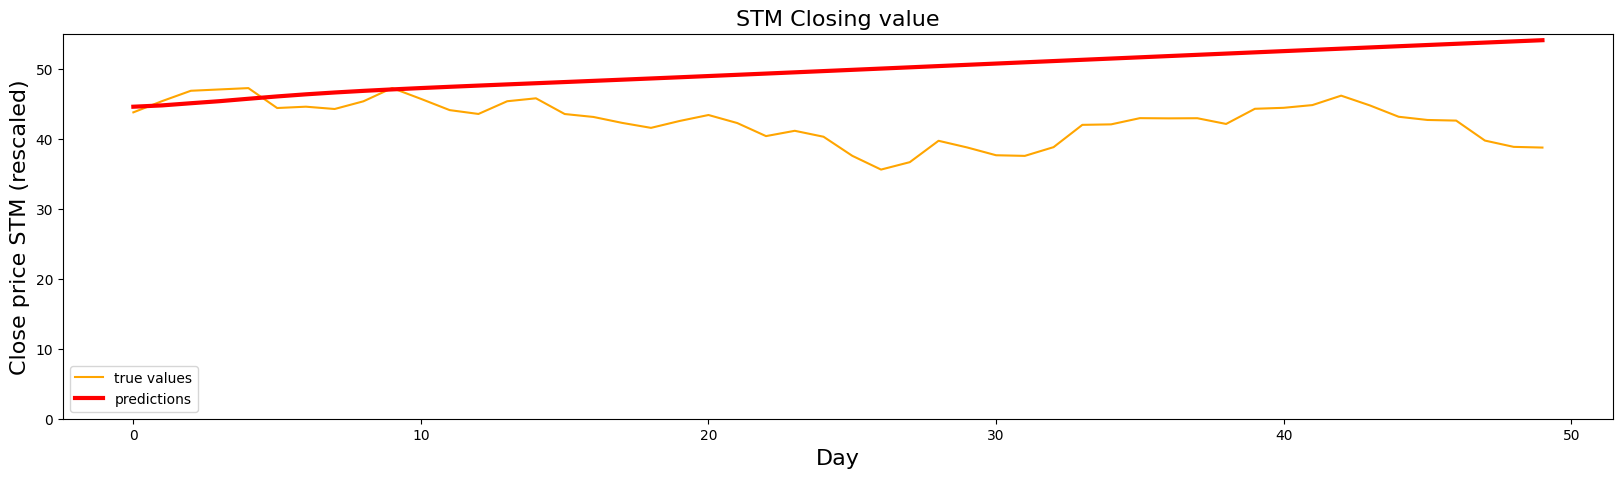

In [94]:
plt.figure(figsize=(20,5))
plt.plot(y_test_rev_scaled[1,:-1,3], c='orange',label='true values')
plt.plot(new_prediction_rev_scaled[1,:-1,3], lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("Day", fontsize=16)
plt.ylabel("Close price STM (rescaled)", fontsize=16)
plt.title("STM Closing value", fontsize=16);
plt.ylim(0)

In [95]:
def trend_extractor(array, Choice):
  trend_array = np.array([])
  data_indices = {'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Adj Close': 4, 'Volume': 5}
  idx = data_indices[Choice]

  array = array[:,0:-1,idx]
  print("Array shape", array.shape)
  for i in array:
    if i[-1] > i[0]:
      trend = 1
    elif i[-1] < i[0]:
      trend = -1
    elif i[-1] == i[0]:
      trend = 0
    else:
      print("No comparison is made")
    trend_array = np.append(trend_array, trend)
  return trend_array

In [96]:
prediction_trend = trend_extractor(new_prediction_rev_scaled, Choice="Close")
y_test_trend = trend_extractor(y_test_rev_scaled, Choice="Close")

accuracy1 = np.mean(y_test_trend == prediction_trend)
print("Accuracy of Closing Price for 50 days prediction is", accuracy1*100, "%")

Array shape (483, 50)
Array shape (483, 50)
Accuracy of Closing Price for 50 days prediction is 46.790890269151134 %
